# Illegal Mining
<hr>
# Notebook Summary

<hr>
# Algorithmic process  

* [Import dependencies and connect to the datacube](#import)
* [Choose platform and product](#plat_prod)
* [Get the maximum extents of the datacube](#extents)
* [Define extents you require that fall within the maximum extents](#define_extents) (selecting too much can make the acquisition process slow)
* [Retrieve the data from the datacube](#retrieve_data)
* [Obtain the clean mask](#obtain_clean_mask)
* [Filter out clouds, scan lines, and invalid data](#clean_mask)
* [Calculate NDVI, WOFS, and NDWI](#calculate)
* [Examine the selected area](#area_analysis)

<hr>
# How It Works



## <a id="import">Import Dependencies and Connect to the Data Cube</a>

In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
import datetime as dt
import numpy as np
import xarray as xr

from matplotlib.colors import LinearSegmentedColormap

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/psycopg2-2.7.5-py3.5-linux-x86_64.egg/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create an instance of the datacube and API.
api = DataAccessApi(config="/home/localuser/.datacube.conf")
dc = api.dc

## <a id="plat_prod">Choose Platform and Product</a>

**List available products for each platform**

In [3]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
0,LANDSAT_7,ls7_collections_sr_scene
1,LANDSAT_7,ls7_ledaps_ghana
2,LANDSAT_7,ls7_ledaps_ghana_sample


In [4]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,


**Choose products**

In [5]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration.
use_Landsat7 = True
use_Landsat8 = False
platforms = []
products = []
if use_Landsat7:
    platforms.append('LANDSAT_7')
    products.append('ls7_ledaps_ghana_sample')
# if use_Landsat8:
#     platforms.append('LANDSAT_8')
#     products.append('ls8_lasrc_ghana')

## <a id="extents">Get the Extents of the Cube</a>

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map

min_max_dates = np.empty((len(platforms), 2), dtype=object)
min_max_lat = np.empty((len(platforms), 2))
min_max_lon = np.empty((len(platforms), 2))
for i, (platform, product) in enumerate(zip(platforms, products)):
    # Get the extents of the cube
    descriptor = api.get_query_metadata(platform=platform, product=product)

    # Save extents
    min_max_dates[i] = descriptor['time_extents']
    min_max_lat[i] = descriptor['lat_extents']
    min_max_lon[i] = descriptor['lon_extents']
    
# Determine minimum and maximum longitudes that bound a common area among products
min_lon = np.max(min_max_lon[:,0]) # The greatest minimum longitude among products
max_lon = np.min(min_max_lon[:,1]) # The smallest maximum longitude among products
min_lat = np.max(min_max_lat[:,0])
max_lat = np.min(min_max_lat[:,1])
full_lon = (min_lon, max_lon)
full_lat = (min_lat, max_lat)
# Display the total shared area available for these datacube products.
display_map(latitude = full_lat,longitude = full_lon)

/home/localuser/Datacube/data_cube_notebooks/utils/data_cube_utilities/data_access_api.py:184: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  if not dataset:


## <a id="define_extents">Define the Extents of the Analysis</a>

**Specify start and end dates in the same order as platforms and products**

In [7]:
# Use these four lines to select the time slice common to all products.
# min_start_date_mutual = np.max(min_max_dates[:,0])
# max_end_date_mutual = np.min(min_max_dates[:,1])
# start_dates = [min_start_date_mutual, min_start_date_mutual]
# end_dates = [max_end_date_mutual, max_end_date_mutual]
# Use these two lines to select all data available to each product.
# start_dates = min_max_dates[:,0]
# end_dates = min_max_dates[:,1]
# Select a subset of the time available.
start_dates = (dt.datetime(2016,1,1), dt.datetime(2016,1,1))
end_dates = (dt.datetime(2017,12,1), dt.datetime(2017,12,1))

**Specify an area to analyze**

**No data returned**

In [8]:
# min_lat_small, max_lat_small = (0.5393, 0.7664) # Lake Baringo (Kenya)
# min_lon_small, max_lon_small = (35.9376, 36.1437) # Lake Baringo (Kenya)

**Large regions**

In [9]:
# min_lat_small, max_lat_small = (8.4, 9.4) # Ghana (full)
# min_lon_small, max_lon_small = (-1.6, -0.6) # Ghana (full)
min_lat_small, max_lat_small = (8.85, 8.9) # Ghana (small)
min_lon_small, max_lon_small = (-1.75, -1.7) # Ghana (small)
# min_lat_small, max_lat_small = (6.2, 6.4) # Ghana (Illegal Mining - Bibiani Forest District)
# min_lon_small, max_lon_small = (-2.25, -2.05) # Ghana (Illegal Mining - Bibiani Forest District)
# min_lat_small, max_lat_small = (6.225, 6.3) # Ghana (Illegal Mining - Begoro Forest District)
# min_lon_small, max_lon_small = (-0.575,-0.525) # Ghana (Illegal Mining - Begoro Forest District)
# min_lat_small, max_lat_small = (5.05, 5.15) # Ghana (Ampansie - Southwest - Brian region)
# min_lon_small, max_lon_small = (-2.30,-2.20) # Ghana (Ampansie - Southwest - Brian region)
# min_lat_small, max_lat_small = (6.1, 6.2) # Ghana (Illegal Mining - Kade Forest District)
# min_lon_small, max_lon_small = (-0.85, -0.75) # Ghana (Illegal Mining - Kade Forest District)
# min_lat_small, max_lat_small = (5.10, 5.14) # Ghana (Brian-SOUTH)
# min_lon_small, max_lon_small = (-2.26, -2.22) # Ghana (Brian-SOUTH)
# min_lat_small, max_lat_small = (6.7083,6.7285) # Ghana (research paper)
# min_lon_small, max_lon_small = (-2.0750,-2.0183) # Ghana (research paper)

**Small regions (sites)**

In [10]:
# Specify latitude and longitude bounds of an interesting area within the full extents.
# shown in the metadata report above (reduce area for faster processing times).

# No conclusive results.
# min_lat_small, max_lat_small = (5.51, 5.52) # Tarkwa Forest District #1
# min_lon_small, max_lon_small = (-1.837, -1.827) # Tarkwa Forest District #1

# min_lat_small, max_lat_small = (6.5016, 6.5821) # Lake Volta (WOFS Test)
# min_lon_small, max_lon_small = (-0.1618, -0.055) # Lake Volta (WOFS Test)
# min_lat_small, max_lat_small = (6.5116, 6.5321) # Lake Volta (WOFS Test small)
# min_lon_small, max_lon_small = (-0.1618, -0.155) # Lake Volta (WOFS Test small)

# Choose an interesting point within the specified area (a pixel, not an area).

# lat_point, lon_point = (8.875, -1.70)
# lat_point, lon_point = (5.12, -2.24) # Ghana (Ampansie - Southwest -Brian region)
# lat_point, lon_point = (6.7204, -2.0266) # Ghana (research paper - POI 1)
# lat_point, lon_point = (6.7176, -2.0310) # Ghana (research paper - POI 2)
# lat_point, lon_point = (5.1143, -2.2430) # Ghana (Brian-SOUTH) #1
# lat_point, lon_point = (5.1110, -2.2463) # Ghana (Brian-SOUTH) #2
# lat_point, lon_point = (6.203758489, -1.419891117) #(Illegal Mining - median)

**Visualize the selected area**

In [11]:
lon_small = (min_lon_small, max_lon_small)
lat_small = (min_lat_small, max_lat_small)
display_map(lat_small, lon_small)

## <a id="retrieve_data">Retrieve the data from the datacube</a>

In [12]:
from utils.data_cube_utilities import dc_mosaic
from utils.data_cube_utilities import clean_mask
import importlib
importlib.reload(dc_mosaic)
importlib.reload(clean_mask)

from datetime import datetime as dt
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid

cleaned_datasets = {}
clean_masks = {}
water_masks = {}
measurements = ['red', 'blue', 'green', 'nir', 'swir1', 'swir2', 'pixel_qa']
for i, (product,platform) in enumerate(zip(products, platforms)):
    start_date = start_dates[i]
    end_date = end_dates[i]
    # Query the Data Cube
    dataset = dc.load(lat = lat_small,
                      lon = lon_small,
                      platform = platform,
                      time = (start_date, end_date),
                      product = product,
                      measurements = measurements)
    if len(dataset.dims) > 0: # Sometimes data is not returned.
        # Get the clean mask for the appropriate LANDSAT satellite platform.
        clean_mask = landsat_qa_clean_mask(dataset, platform)
        clean_masks[platform] = clean_mask
        # Remove clouds.
        cleaned_dataset = dataset.where(clean_mask)
        # Remove data that is ouside the accepted range of LANDSAT 7 and 8.
        cleaned_dataset = landsat_clean_mask_invalid(cleaned_dataset)
        cleaned_datasets[platform] = cleaned_dataset
        # Get a mask for points in the retrieved datacube which this Landsat platforms' pixel_qa band classifies as water.
        water_masks[platform] = landsat_qa_clean_mask(dataset, platform, cover_types=['water'])
assert len(cleaned_datasets) > 0, "No data was retrieved."

**Combine the data**

In [13]:
from utils.data_cube_utilities.sort import xarray_sortby_coord
if len(cleaned_datasets) > 1: # If mutliple non-empty datasets were retrieved, merge them and sort by time.
    # Merge datasets.
    cleaned_datasets_list = list(cleaned_datasets.values())
    cleaned_dataset = xr.concat(cleaned_datasets_list, dim='time')
    cleaned_dataset = xarray_sortby_coord(cleaned_dataset, 'time')
    # Merge water masks.
    water_masks_list = list(water_masks.values())
    water_mask = xr.concat(water_masks_list, dim='time')
    water_mask = xarray_sortby_coord(water_mask, 'time')
else: # Select the first.
    cleaned_dataset = cleaned_datasets[list(cleaned_datasets.keys())[0]]
    water_mask = water_masks[list(water_masks.keys())[0]]

## <a id="calculate">Calculate NDVI, WOFS, and NDWI</a>

In [14]:
from utils.data_cube_utilities.dc_ndvi_anomaly import NDVI
from utils.data_cube_utilities.dc_water_classifier import NDWI, wofs_classify
from utils.data_cube_utilities.dc_utilities import ignore_warnings
# NDVI
ndvi_arr = NDVI(cleaned_dataset)
cleaned_dataset['ndvi'] = ndvi_arr
# WOFS
wofs_arr = ignore_warnings(wofs_classify, cleaned_dataset).wofs
wofs_arr = wofs_arr.where(wofs_arr!=-9999)
cleaned_dataset['wofs'] = wofs_arr
# NDWI
ndwi_arr = NDWI(cleaned_dataset)
cleaned_dataset['ndwi'] = ndwi_arr

## <a id="area_analysis">Examine the selected area</a>

In [15]:
from utils.data_cube_utilities import clean_mask
import importlib
importlib.reload(clean_mask)

ls_wtr_cls = cleaned_dataset.red.copy()
ls_wtr_cls.name = 'ls_wtr_cls'
ls_wtr_cls.values = water_mask.astype(ls_wtr_cls.dtype)
cleaned_dataset['ls_wtr_cls'] = ls_wtr_cls

In [16]:
print(cleaned_dataset)

<xarray.Dataset>
Dimensions:     (latitude: 186, longitude: 186, time: 5)
Coordinates:
  * time        (time) datetime64[ns] 2016-01-13T10:28:52 ...
  * latitude    (latitude) float64 8.9 8.9 8.899 8.899 8.899 8.899 8.898 ...
  * longitude   (longitude) float64 -1.75 -1.75 -1.749 -1.749 -1.749 -1.749 ...
Data variables:
    red         (time, latitude, longitude) float64 nan nan 1.102e+03 ...
    blue        (time, latitude, longitude) float64 nan nan 671.0 671.0 ...
    green       (time, latitude, longitude) float64 nan nan 806.0 806.0 ...
    nir         (time, latitude, longitude) float64 nan nan 1.928e+03 ...
    swir1       (time, latitude, longitude) float64 nan nan 2.551e+03 ...
    swir2       (time, latitude, longitude) float64 nan nan 1.819e+03 ...
    pixel_qa    (time, latitude, longitude) float64 nan nan 66.0 66.0 66.0 ...
    ndvi        (time, latitude, longitude) float64 nan nan 0.2726 0.2 0.187 ...
    wofs        (time, latitude, longitude) float64 0.0 0.0 0.0 0.0 0.

## Box-and-Whisker Plot by Full Time Period, Week, Month, Week of Year, or Month of Year.

### Plot of Mean by Month

NDVI and WOFS (Mean by Month)


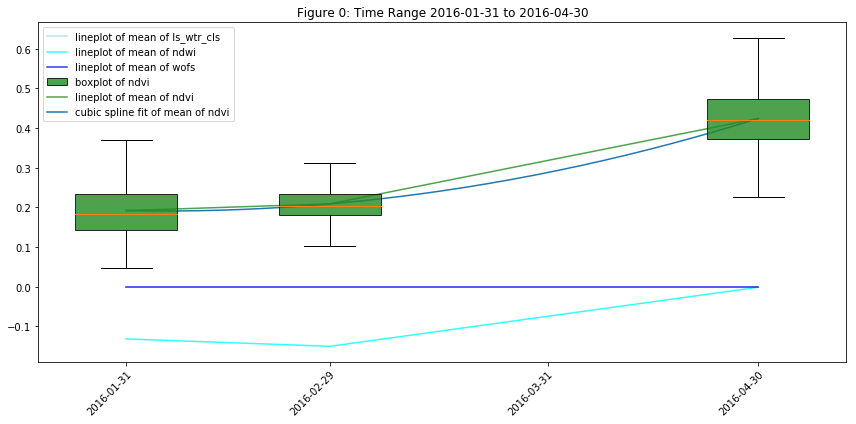

In [17]:
from utils.data_cube_utilities import plotter_utils
import importlib
importlib.reload(plotter_utils)
from utils.data_cube_utilities.plotter_utils import xarray_time_series_plot

# Specify whether to plot a cubic spline curve fit of NDVI.
plot_cubic_spline_ndvi = True

ndvi_color = 'forestgreen'
wofs_color = 'blue'
ls_wtr_cls_color = 'lightblue'
ndwi_color = 'aqua'
alpha = 0.8 # Standard amount of transparency.

# Can be one of [None, 'week', 'month', 'weekofyear', 'monthofyear'].
# for bin_by in [None, 'week', 'month', 'weekofyear', 'monthofyear']:
for bin_by in ['month']:
    aggregated_by_str = None
    if bin_by is None:
        plotting_data = cleaned_dataset
    elif bin_by == 'week':
        plotting_data = cleaned_dataset.resample(time='1w').mean()
        aggregated_by_str = 'Week'
    elif bin_by == 'month':
        plotting_data = cleaned_dataset.resample(time='1m').mean()
        aggregated_by_str = 'Month'
    elif bin_by == 'weekofyear':
        plotting_data = cleaned_dataset.groupby('time.week').mean(dim=('time'))
        aggregated_by_str = 'Week of Year'
    elif bin_by == 'monthofyear':
        plotting_data = cleaned_dataset.groupby('time.month').mean(dim=('time'))
        aggregated_by_str = 'Month of Year'
    
    params = dict(dataset=plotting_data, 
              plot_descs={'ndvi':       {'mean': [{'line': {'color': ndvi_color, 'alpha':alpha}}],
                                         'none':  [{'box': {'boxprops': {'facecolor':ndvi_color, 'alpha':alpha}, 
                                                            'showfliers':False}}]},
                          'wofs':       {'mean': [{'line': {'color': wofs_color, 'alpha':alpha}}]},
                          'ls_wtr_cls': {'mean': [{'line': {'color': ls_wtr_cls_color, 'alpha':alpha}}]},
                          'ndwi':       {'mean': [{'line': {'color': ndwi_color, 'alpha':alpha}}]}},
              fig_params={'figsize':(12,6)})
    if plot_cubic_spline_ndvi:
        params['plot_descs']['ndvi']['mean'].append({'cubic_spline':{}})
    xarray_time_series_plot(**params)
    print("NDVI and WOFS {}".format("(Mean by {})".format(aggregated_by_str) if aggregated_by_str is not None else ""))

### Plot of Median by Month

NDVI and WOFS (Median by Month)


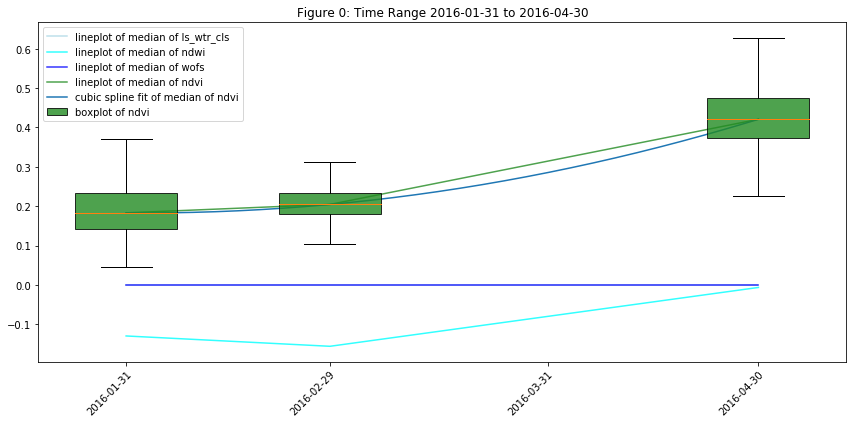

In [18]:
from utils.data_cube_utilities import plotter_utils
import importlib
importlib.reload(plotter_utils)
from utils.data_cube_utilities.plotter_utils import xarray_time_series_plot

# Specify whether to plot a cubic spline curve fit of NDVI.
plot_cubic_spline_ndvi = True

ndvi_color = 'forestgreen'
wofs_color = 'blue'
ls_wtr_cls_color = 'lightblue'
ndwi_color = 'aqua'
alpha = 0.8 # Standard amount of transparency.

# Can be one of [None, 'week', 'month', 'weekofyear', 'monthofyear'].
# for bin_by in [None, 'week', 'month', 'weekofyear', 'monthofyear']:
for bin_by in ['month']:
    aggregated_by_str = None
    if bin_by is None:
        plotting_data = cleaned_dataset
    elif bin_by == 'week':
        plotting_data = cleaned_dataset.resample(time='1w').median()
        aggregated_by_str = 'Week'
    elif bin_by == 'month':
        plotting_data = cleaned_dataset.resample(time='1m').median()
        aggregated_by_str = 'Month'
    elif bin_by == 'weekofyear':
        plotting_data = cleaned_dataset.groupby('time.week').median(dim=('time'))
        aggregated_by_str = 'Week of Year'
    elif bin_by == 'monthofyear':
        plotting_data = cleaned_dataset.groupby('time.month').median(dim=('time'))
        aggregated_by_str = 'Month of Year'
    
    params = dict(dataset=plotting_data, 
              plot_descs={'ndvi':       {'median': [{'line': {'color': ndvi_color, 'alpha':alpha}}],
                                         'none':  [{'box': {'boxprops': {'facecolor':ndvi_color, 'alpha':alpha}, 
                                                            'showfliers':False}}]},
                          'wofs':       {'median': [{'line': {'color': wofs_color, 'alpha':alpha}}]},
                          'ls_wtr_cls': {'median': [{'line': {'color': ls_wtr_cls_color, 'alpha':alpha}}]},
                          'ndwi':       {'median': [{'line': {'color': ndwi_color, 'alpha':alpha}}]}},
              fig_params={'figsize':(12,6)})
    if plot_cubic_spline_ndvi:
        params['plot_descs']['ndvi']['median'].append({'cubic_spline':{}})
    xarray_time_series_plot(**params)
    print("NDVI and WOFS {}".format("(Median by {})".format(aggregated_by_str) if aggregated_by_str is not None else ""))

### Plot of Mean by Week

NDVI and WOFS (Mean by Week)


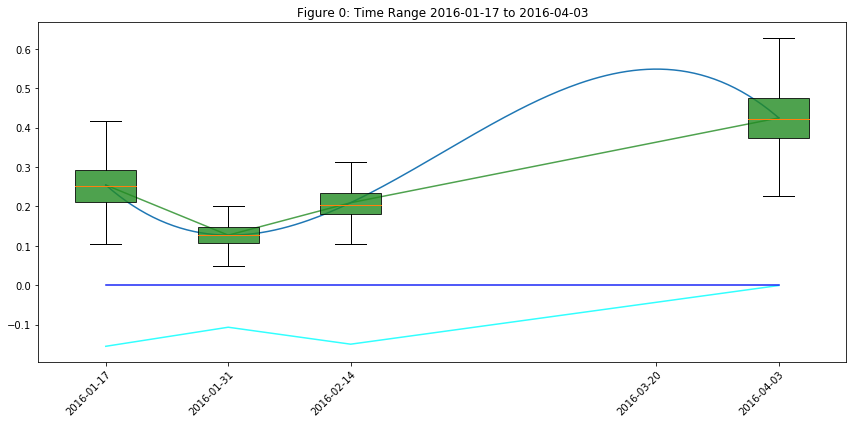

In [19]:
from utils.data_cube_utilities import plotter_utils
import importlib
importlib.reload(plotter_utils)
from utils.data_cube_utilities.plotter_utils import xarray_time_series_plot

# Specify whether to plot a cubic spline curve fit of NDVI.
plot_cubic_spline_ndvi = True

ndvi_color = 'forestgreen'
wofs_color = 'blue'
ls_wtr_cls_color = 'lightblue'
ndwi_color = 'aqua'
alpha = 0.8 # Standard amount of transparency.

# Can be one of [None, 'week', 'month', 'weekofyear', 'monthofyear'].
# for bin_by in [None, 'week', 'month', 'weekofyear', 'monthofyear']:
for bin_by in ['week']:
    aggregated_by_str = None
    if bin_by is None:
        plotting_data = cleaned_dataset
    elif bin_by == 'week':
        plotting_data = cleaned_dataset.resample(time='1w').mean()
        aggregated_by_str = 'Week'
    elif bin_by == 'month':
        plotting_data = cleaned_dataset.resample(time='1m').mean()
        aggregated_by_str = 'Month'
    elif bin_by == 'weekofyear':
        plotting_data = cleaned_dataset.groupby('time.week').mean(dim=('time'))
        aggregated_by_str = 'Week of Year'
    elif bin_by == 'monthofyear':
        plotting_data = cleaned_dataset.groupby('time.month').mean(dim=('time'))
        aggregated_by_str = 'Month of Year'
    
    params = dict(dataset=plotting_data, 
              plot_descs={'ndvi':       {'mean': [{'line': {'color': ndvi_color, 'alpha':alpha}}],
                                         'none':  [{'box': {'boxprops': {'facecolor':ndvi_color, 'alpha':alpha}, 
                                                            'showfliers':False}}]},
                          'wofs':       {'mean': [{'line': {'color': wofs_color, 'alpha':alpha}}]},
                          'ls_wtr_cls': {'mean': [{'line': {'color': ls_wtr_cls_color, 'alpha':alpha}}]},
                          'ndwi':       {'mean': [{'line': {'color': ndwi_color, 'alpha':alpha}}]}},
              fig_params={'figsize':(12,6)}, show_legend=False)
    if plot_cubic_spline_ndvi:
        params['plot_descs']['ndvi']['mean'].append({'cubic_spline':{}})
    xarray_time_series_plot(**params, max_times_per_plot=20)
    print("NDVI and WOFS {}".format("(Mean by {})".format(aggregated_by_str) if aggregated_by_str is not None else ""))

### Plot of Median by Week

NDVI and WOFS (Median by Week)


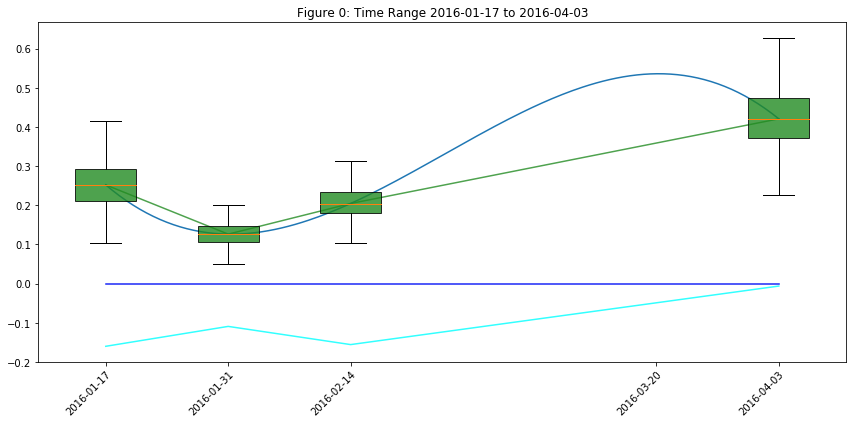

In [20]:
from utils.data_cube_utilities import plotter_utils
import importlib
importlib.reload(plotter_utils)
from utils.data_cube_utilities.plotter_utils import xarray_time_series_plot

# Specify whether to plot a cubic spline curve fit of NDVI.
plot_cubic_spline_ndvi = True

ndvi_color = 'forestgreen'
wofs_color = 'blue'
ls_wtr_cls_color = 'lightblue'
ndwi_color = 'aqua'
alpha = 0.8 # Standard amount of transparency.

# Can be one of [None, 'week', 'month', 'weekofyear', 'monthofyear'].
# for bin_by in [None, 'week', 'month', 'weekofyear', 'monthofyear']:
for bin_by in ['week']:
    aggregated_by_str = None
    if bin_by is None:
        plotting_data = cleaned_dataset
    elif bin_by == 'week':
        plotting_data = cleaned_dataset.resample(time='1w').median()
        aggregated_by_str = 'Week'
    elif bin_by == 'month':
        plotting_data = cleaned_dataset.resample(time='1m').median()
        aggregated_by_str = 'Month'
    elif bin_by == 'weekofyear':
        plotting_data = cleaned_dataset.groupby('time.week').median(dim=('time'))
        aggregated_by_str = 'Week of Year'
    elif bin_by == 'monthofyear':
        plotting_data = cleaned_dataset.groupby('time.month').median(dim=('time'))
        aggregated_by_str = 'Month of Year'
    
    params = dict(dataset=plotting_data, 
              plot_descs={'ndvi':       {'median': [{'line': {'color': ndvi_color, 'alpha':alpha}}],
                                         'none':  [{'box': {'boxprops': {'facecolor':ndvi_color, 'alpha':alpha}, 
                                                            'showfliers':False}}]},
                          'wofs':       {'median': [{'line': {'color': wofs_color, 'alpha':alpha}}]},
                          'ls_wtr_cls': {'median': [{'line': {'color': ls_wtr_cls_color, 'alpha':alpha}}]},
                          'ndwi':       {'median': [{'line': {'color': ndwi_color, 'alpha':alpha}}]}},
              fig_params={'figsize':(12,6)}, show_legend=False)
    if plot_cubic_spline_ndvi:
        params['plot_descs']['ndvi']['median'].append({'cubic_spline':{}})
    xarray_time_series_plot(**params, max_times_per_plot=20)
    print("NDVI and WOFS {}".format("(Median by {})".format(aggregated_by_str) if aggregated_by_str is not None else ""))